# Assignment 1

* Target - Ilia
* Audio source - Google speech synthesis (`name.wav`)
* GitHub repo - [Signals_Assignment_1](https://github.com/someilay/Signals_Assignment_1.git)

### Imports

In [58]:
import numpy as np
import thinkdsp as dsp
import matplotlib.pyplot as plt

from typing import Tuple
from thinkdsp import SinSignal, SawtoothSignal
from scipy.signal import quadratic

np.set_printoptions(precision=4, suppress=True)

In [59]:
class QuadraticSignal(dsp.Sinusoid):
    """Represents a quadratic signal."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times

        returns: float wave array
        """
        ts = np.asarray(ts)
        cycles = self.freq * ts + self.offset / (np.pi * 2)
        frac, _ = np.modf(cycles)
        ys = quadratic(frac)
        ys = dsp.normalize(dsp.unbias(ys), self.amp)
        return ys

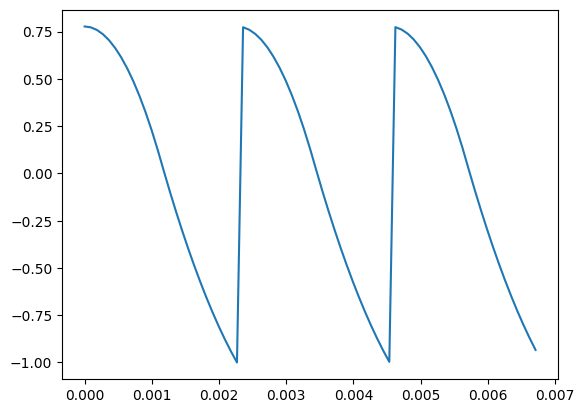

In [60]:
# Example
QuadraticSignal().plot()

### Part 1. Generate single letter pronunciation

* Each letter extracted from source audio (`i.wav`, `l_soft.wav`, `a.wav`)
* Note: second 'i' is hard to extract because it blends with neighbours sounds, so I will use first 'i' twice

In [62]:
def generate_wave(source_path: str, max_freq: float = 3500, amount_of_peaks: int = 75) -> Tuple[dsp.Wave, dsp.Wave]:
    # Read source audion
    _wave = dsp.read_wave(source_path)
    _wave.plot()
    dsp.decorate(xlabel='$t, s$', title=f'{source_path}, original wave')
    plt.show()

    # Create a spectrum and find peak values
    _spectrum = _wave.make_spectrum()
    _amps = _spectrum.amps
    _hs = _spectrum.hs
    _fs = _spectrum.fs
    peaks_indices = np.argpartition(_amps, -amount_of_peaks)[-amount_of_peaks:]

    # Plot spectrum with peaks
    _spectrum.plot()
    plt.plot(_fs[peaks_indices], _amps[peaks_indices], 's', color='r', markersize=5)
    dsp.decorate(
        xlabel=r'$\nu$, Hz', xlim=(0, max_freq),
        title=f'{source_path}, original spectrum\nRed points - {amount_of_peaks} peaks value'
    )
    plt.show()

    # Create basic waves according to obtained peaks
    _signals_a: list[dsp.Signal] = [SinSignal(_fs[peak_idx], _amps[peak_idx], np.angle(_hs[peak_idx])) for peak_idx in peaks_indices]
    # SawtoothSignal, QuadraticSignal make final signal sound more natural
    _signals_b: list[dsp.Signal] = [SawtoothSignal(_fs[peak_idx], _amps[peak_idx] / 20, np.angle(_hs[peak_idx])) for peak_idx in peaks_indices]
    _signals_c: list[dsp.Signal] = [QuadraticSignal(_fs[peak_idx], _amps[peak_idx] / 200, np.angle(_hs[peak_idx])) for peak_idx in peaks_indices]

    _signal = dsp.SumSignal(*(_signals_a + _signals_b + _signals_c))  # Sum
    _signal.plot(_wave.framerate)
    dsp.decorate(title=f'{source_path}, proposed (generated) signal')
    plt.show()

    # Create wave based on proposed signal
    _new_wave = _signal.make_wave(duration=_wave.duration, framerate=_wave.framerate)
    _new_wave.normalize()
    _new_wave.plot()
    dsp.decorate(title=f'{source_path}, proposed (generated) wave')
    plt.show()
    return _wave, _new_wave

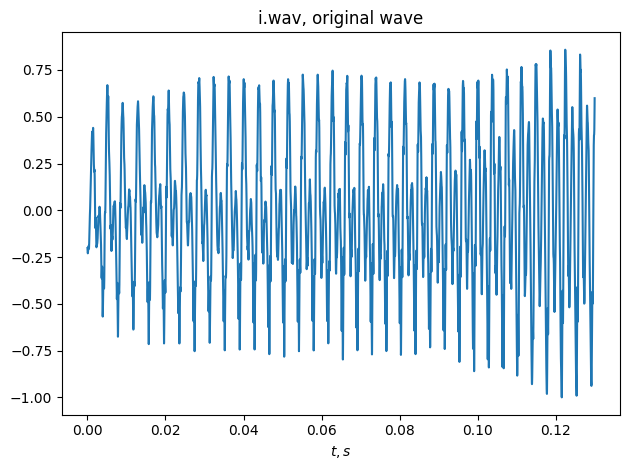

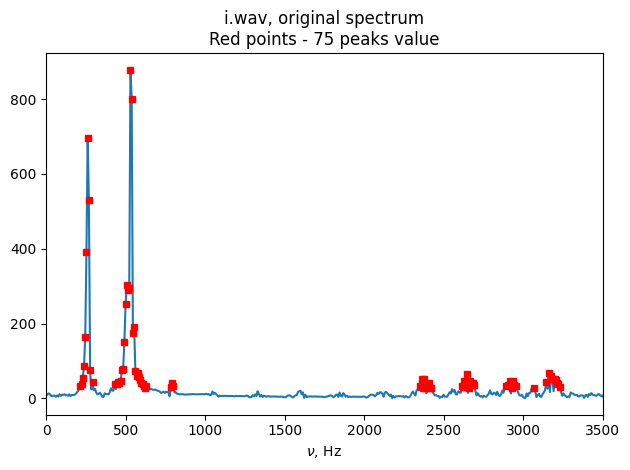

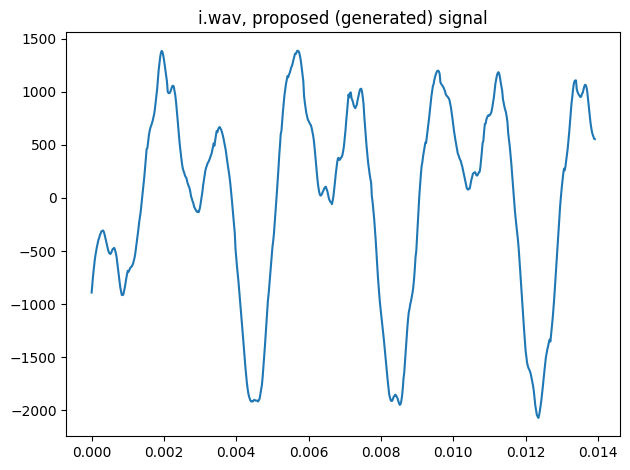

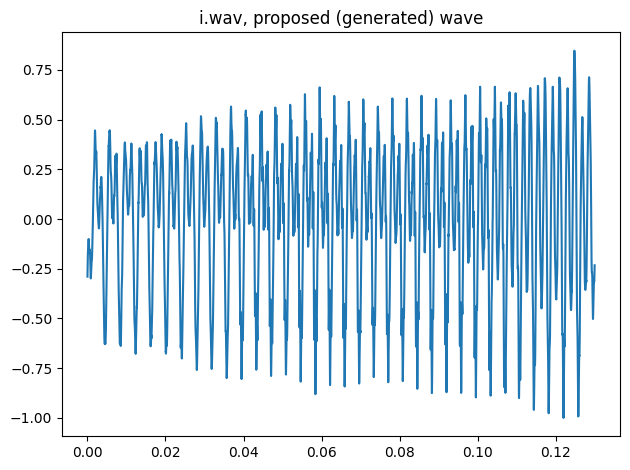

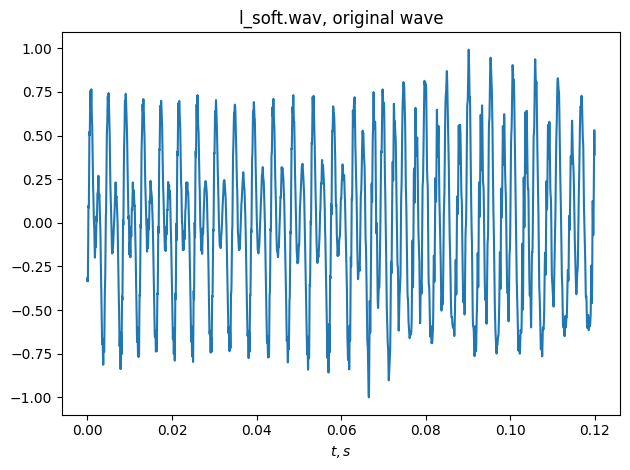

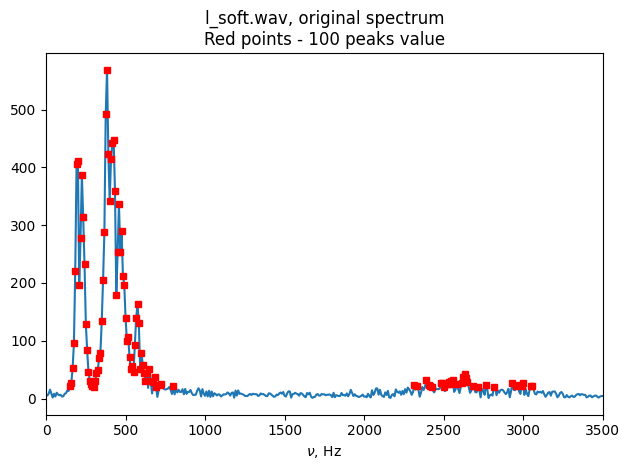

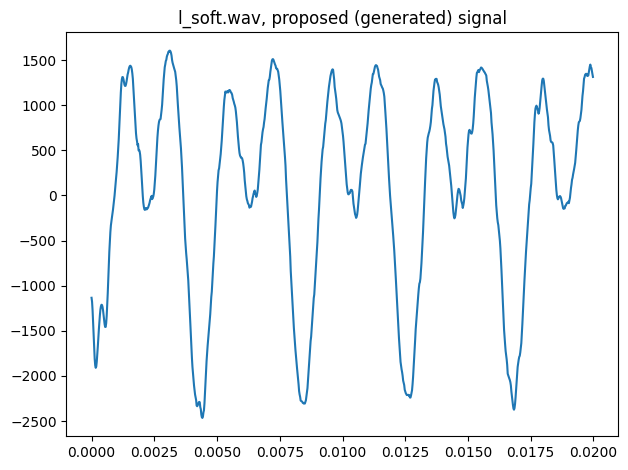

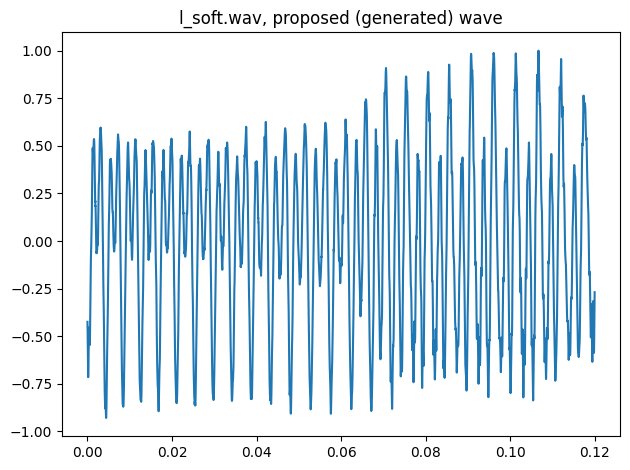

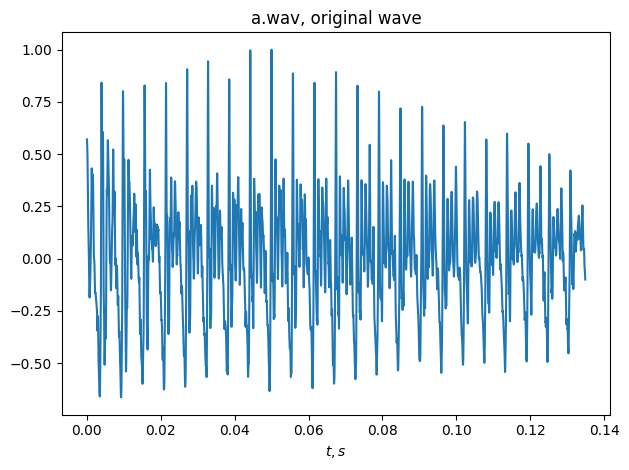

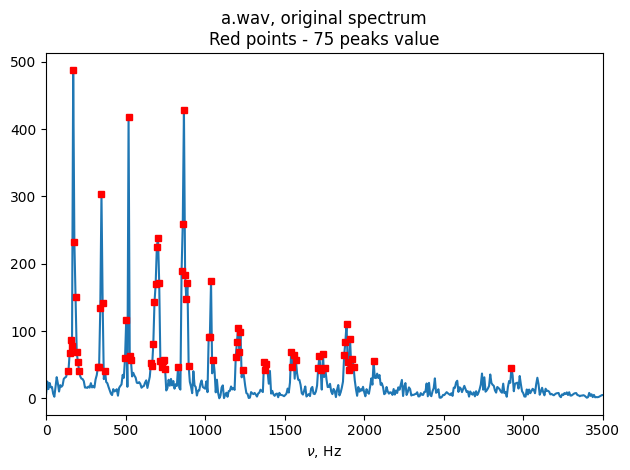

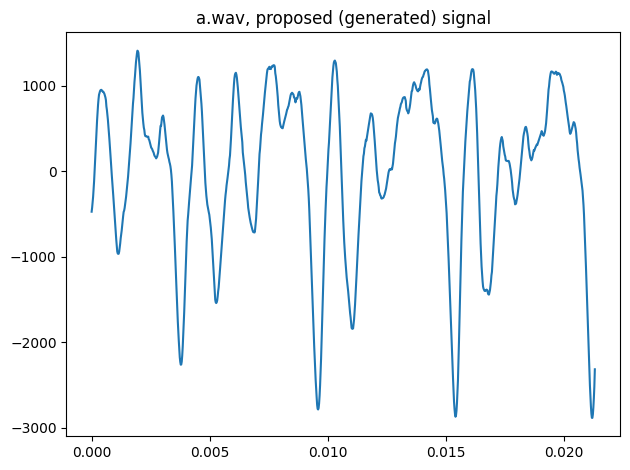

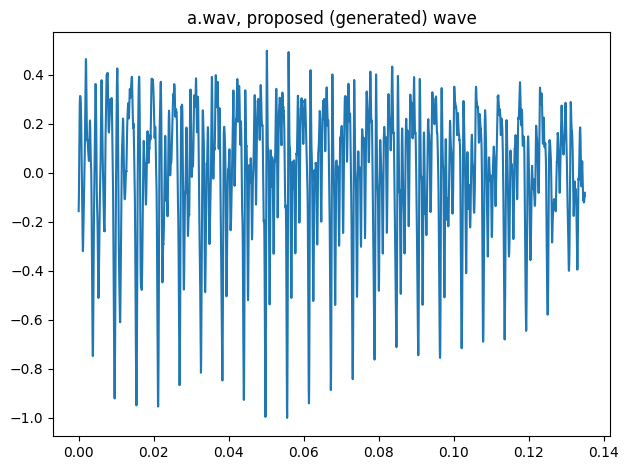

In [5]:
# Generate all necessary waves; plot info
i_wave, gen_i_wave = generate_wave('i.wav')
l_wave, gen_l_wave = generate_wave('l_soft.wav', amount_of_peaks=100)
a_wave, gen_a_wave = generate_wave('a.wav')

In [6]:
i_wave.make_audio()

In [7]:
l_wave.make_audio()

In [8]:
a_wave.make_audio()

In [9]:
gen_i_wave.write('gen_i.wav')
gen_i_wave.make_audio()

Writing gen_i.wav


In [10]:
gen_l_wave.write('gen_l.wav')
gen_l_wave.make_audio()

Writing gen_l.wav


In [11]:
gen_a_wave.write('gen_a.wav')
gen_a_wave.make_audio()

Writing gen_a.wav


### Part 2. Pronounce full name via sound concatenation

In [12]:
gen_name_wave = dsp.Wave(list(gen_i_wave.ys) + list(gen_l_wave.ys) + list(gen_i_wave.ys) + list(gen_a_wave.ys), framerate=gen_l_wave.framerate)
name_wave = dsp.read_wave('name.wav')

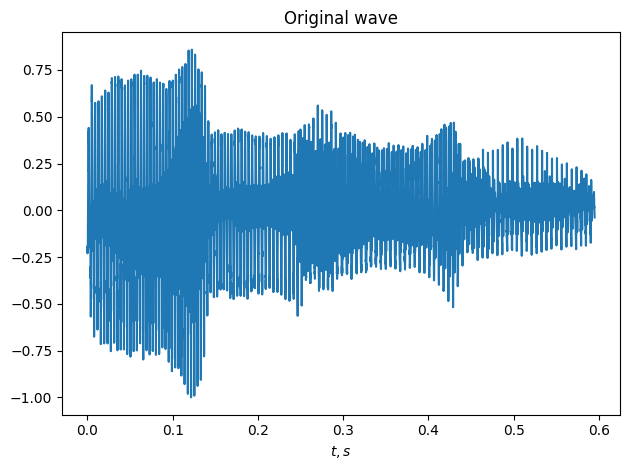

In [13]:
name_wave.plot()
dsp.decorate(xlabel='$t, s$', title='Original wave')

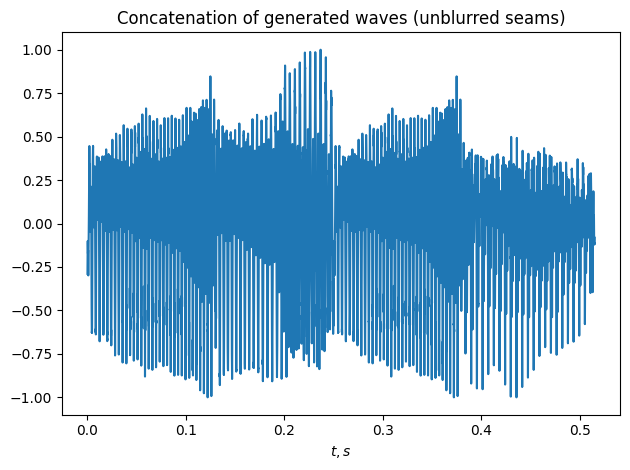

In [14]:
gen_name_wave.plot()
dsp.decorate(xlabel='$t, s$', title='Concatenation of generated waves (unblurred seams)')

In [63]:
# Smooth edges of letter using 2 / [1 + e^(x / a)^2]
# I take only right part of function and consider it like a mask

def smoother_mask(span: np.ndarray, half_val: float, reverse: bool = False):
    """
    Generate smooth mask

    :param span: length of smoothing
    :param half_val: signal's amplitude in the middle of mask (fraction)
    :param reverse: reverse mask
    :return:
    """
    _span_min: float = span[0]
    _length = span[-1] - _span_min
    _a: float = _length / (2 * np.sqrt(np.log(2 / half_val - 1)))
    _filter = np.array([2 / (1 + np.exp(((_x - _span_min) / _a) ** 2)) for _x in span])
    return _filter if not reverse else _filter[::-1]

def smooth(start_len: int, end_len: int, vals: np.ndarray, args: np.ndarray, half_val: float = 0.3) -> np.ndarray:
    """
    Apple mask to signal

    :param start_len: length of smoothing on the start
    :param end_len: length of smoothing at the end
    :param vals: signal itself
    :param args: arguments
    :param half_val: (already described)
    """
    _mask_1 = smoother_mask(args[:start_len], half_val, reverse=True) if start_len else None
    _mask_2 = smoother_mask(args[-end_len:], half_val) if end_len else None
    _res_vals: np.array = vals.copy()

    if _mask_1 is not None:
        _res_vals[:start_len] = _mask_1 * _res_vals[:start_len]
    if _mask_2 is not None:
        _res_vals[-end_len:] = _mask_2 * _res_vals[-end_len:]

    return _res_vals

In [55]:
# Smooth edges of waves and concatenate them
cross_len = 500 # length of intersections between waves
len_iw = len(gen_i_wave.ys)
len_lw = len(gen_l_wave.ys)
len_aw = len(gen_a_wave.ys)

# Indices of edges
seam_indices = [0, len_iw, len_lw, len_iw]
for i in range(1, len(seam_indices)):
    seam_indices[i] += seam_indices[i - 1]

waves = [gen_i_wave, gen_l_wave, gen_i_wave, gen_a_wave]
overall_len = seam_indices[-1] - cross_len * len(seam_indices) + len_aw # Final length of signal
for idx, seam_idx in enumerate(seam_indices):
    true_idx = seam_idx - cross_len * (idx + 1) if seam_idx > 0 else 0 # Calculate when wave should start
    cur_vals = waves[idx].ys
    cur_args = waves[idx].ts

    if idx > 0:
        cur_vals = smooth(cross_len, 0, cur_vals, cur_args)
    if idx < len(seam_indices) - 1:
        cur_vals = smooth(0, cross_len, cur_vals, cur_args)

    # Add leading and padding zeros
    cur_vals = np.array(
        [0] * true_idx + list(cur_vals) + [0] * (overall_len - true_idx - len(cur_vals))
    )
    waves[idx] = dsp.Wave(cur_vals, framerate=waves[idx].framerate)

b_gen_name_wave: dsp.Wave = sum(waves)
b_gen_name_wave.normalize()

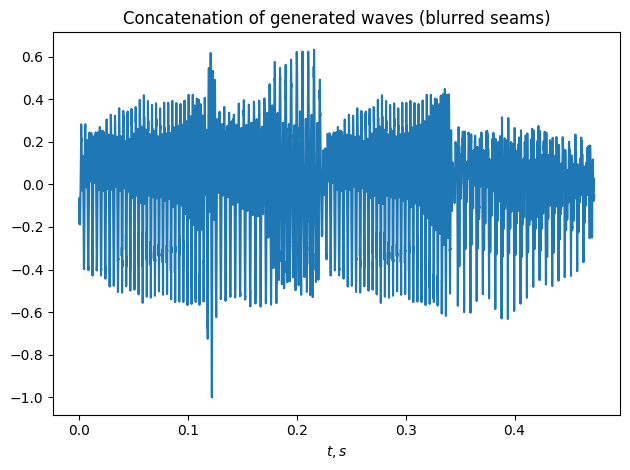

In [65]:
# Result
b_gen_name_wave.plot()
dsp.decorate(xlabel='$t, s$', title='Concatenation of generated waves (blurred seams)')

In [52]:
# Original
name_wave.make_audio()

In [53]:
# Unblurred seams
gen_name_wave.make_audio()

In [57]:
# Final result
b_gen_name_wave.make_audio()